In [ ]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.6.0+cu124


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


# Implementing a GPT model from scrath to generate text

## 4.1 - Coding an LLM architecture

  - GPT (generative pretrained transformer), are large deep neural network architectures designed to generate new text one word at a time.

In [ ]:
#   Specify the configuration of the small GPT-2 model via the following
# Python dictionary, which we will use in the code examples later:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

  - The GPT_CONFIG_124M dictionary, we use concise variable names for clarity and to prevent long lines of code
    - vocab_size : refers to a vocabulary of 50257 words, as used by the BPE tokenizer
    - context_length : denotres the maximum number of input tokens the model can handle via the positional embeddings
    - emb_dim : represents the embedding size, transforming each token into a 768-dimensional vector.
    - n_heads : indicates the count of attention heads in the multi-head attention mechanism
    - n_layer : specifies the number of transformer blocks in the model, which we will cover in the upcoming discussion.
    - drop_rate : indicates the intensity of the dropout mechanism (0.1 implies a 10% random drop_out of hidden units) to prevent overfitting
    - qkv_bias determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations.  We will initially disable this, following the norms of modern LLMs

In [4]:
# A placeholder GPT model architecture class
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
          for _ in range(cfg["n_layers"])]
    )

    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

  - This code defines a simplified version of a GPT-like model using PyTorch's neural network module.
    - DummyGPTModel class consits of token and positional embeddings, droupout, a series of transformer blocks, a final layer normalization, and a linear output layer.
    - The forward method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout, processes the data through the transformer blocks, applies normalization, and finally produces logits with linear output layer.
  - Next prepare the input data and initialize a new GPT model to illustrate its usage.

In [5]:
# Tokenize a batch consisting of two text inputs for the GPT model using the tiktoken
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
#   Initialize a new 124-million-parameter DummyGPTModel instance and feed it
# the tokenized batch:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

Output shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


  - The ouput tensor has two rows corresponding to the two text samples.

## 4.2 - Normalizing activations with layer normalization

  - One of the problems with training deep neural networks with may layers can sometimes prove challenging due to problems like vanishing or exploding gradients.
  - Layer normalization to improve the stability and efficiency of neural network training.
    - layer normalization - adjust the activation (outputs) of a neural network layer to have a mean of 0 and a variance of 1

In [7]:
# Create an example

torch.manual_seed(123)

batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
#   Before applying layer normalization, review mean and variance:

#   The keepdim = True in operations like mean or variance calculation ensures
# ensures ouput tensor retains the same number of dimensions as the input tensor

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
#   dim = -1 for operations such as mean or variance calculations is the same as dim=1

#   Apply layer normalization to the layer outputs

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
#   Improve readability, we turn off scientific notation
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
#   Encapsulate this process in a PyTorch module that we can use in GPT model
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift


  - The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.

In [12]:
#   Let's now try the LayerNorm module in practice and apply it to the batch input:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 - Implementing a feed forward network with GELU activations

  - ReLU activation function is commonly used in deep learning due to its simplicity and effectiveness across various neural networks.
  - GELU (Gaussian error linear unit) and SwiGLU (Swish-gate linear unit)
    - GELU is defined as x*I(x) where I(x) is the cumulative distribution function of the standard Gaussian distribution.

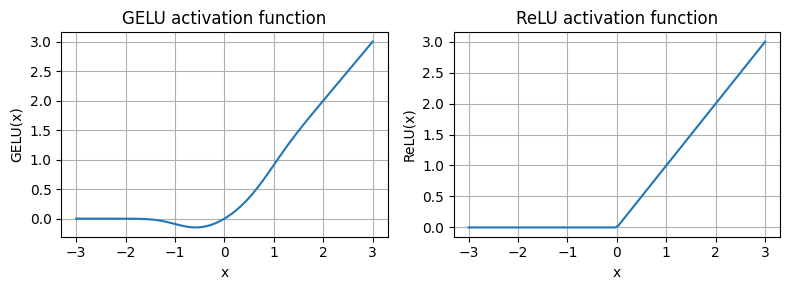

In [13]:
# Implementation of the GELU activation function
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.44715 * torch.pow(x, 3))
    ))

# Compare GELU function vs RELU function
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

  - The smoothness of GELU can lead to better optimization properties during training

In [14]:
#   Use the GELU function to implement the small neural network module
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [15]:
# Let's initialize a new FeedForward module with token embedding size of 768
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


  - The FeedForward module plays a crucial role in enhancing the model's ability to learn from and generalize the data.
  - The input and output dimensions of this module are the same, it expands the embedding dimension into a highter-dimensional space through the first linear layer

## 4.4 - Adding shorcut connections

  - Gradient problem referes to the issue where gradients become progressively smaller as they propagate backward through the layers
  - Shortcut connections (also known as skip or residual connection) - the vanishing creates an alternative shorter path for the gradient to flow through the network by skipping one or more layers.

In [16]:
#   A neural network to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                      GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

#   The code implements a deep neural network with five layers, each consisting
# of a Linear layer and GELU activation function.

#  Lets initialize a neural network without shortcut connections.
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

# implement a function that computes the gradients in the model's backward pass
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
